In [21]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Create dataframe

Data downloaded from [NYC Open Data](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9).

## Create column grouping agencies with fewest calls

In [22]:
df_url = '/Users/sambarrows/Dropbox/Stats/Projects/predict311/311_Service_Requests_from_2010_to_Present.csv'
df = pd.read_csv(df_url, chunksize=100000, low_memory=False)

In [25]:
d = df.get_chunk(100000)    # nb. will move onto next chunk each time run it, 
                            # so if want same result need to read in df again

# remove white space from column names
d.columns = d.columns.str.replace('\s+', '')

d.head(3)

,UniqueKey,CreatedDate,ClosedDate,Agency,AgencyName,ComplaintType,Descriptor,LocationType,IncidentZip,IncidentAddress,...,BridgeHighwayName,BridgeHighwayDirection,RoadRamp,BridgeHighwaySegment,GarageLotName,FerryDirection,FerryTerminalName,Latitude,Longitude,Location
200000,38862584,04/04/2018 01:34:00 PM,04/04/2018 02:55:00 PM,DOT,Department of Transportation,Traffic Signal Condition,Controller,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200001,38862585,04/04/2018 01:22:56 PM,04/05/2018 11:28:01 AM,DOF,Department of Finance,DOF Literature Request,SCHE Initial Application,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200002,38862587,04/04/2018 12:01:54 PM,04/04/2018 02:21:15 PM,NYPD,New York City Police Department,Illegal Parking,Double Parked Blocking Traffic,Street/Sidewalk,10451,283 EAST 161 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.825416,-73.917921,"(40.82541558960748, -73.91792141618167)"


In [226]:
ag = d.groupby('Agency')['UniqueKey'].count().sort_values(ascending=False)
ag

Agency
DSNY     26852
NYPD     17338
DEP      15367
DOT      14134
HPD       7512
DOB       3838
DOHMH     3586
DPR       2373
DOF       2272
TLC       2191
DHS       1587
FDNY      1132
DCA        919
HRA        389
DFTA       186
EDC        117
DOITT       77
DOE         46
3-1-1       35
DCAS        22
CHALL       14
ACS          8
TAX          4
DOP          1
Name: UniqueKey, dtype: int64

In [227]:
agencies = list(ag.index)[:10]
agencies

['DSNY', 'NYPD', 'DEP', 'DOT', 'HPD', 'DOB', 'DOHMH', 'DPR', 'DOF', 'TLC']

In [228]:
# create column giving agency if one of top 15 agencies contacted, or other otherwise
d['KeyAgencies'] = d['Agency'].apply(lambda x: x if x in agencies else 'other')
d.groupby('KeyAgencies')['UniqueKey'].count().sort_values(ascending=False)

KeyAgencies
DSNY     26852
NYPD     17338
DEP      15367
DOT      14134
HPD       7512
other     4537
DOB       3838
DOHMH     3586
DPR       2373
DOF       2272
TLC       2191
Name: UniqueKey, dtype: int64

# Break dataframe into chunks and process

In [229]:
import math
def custom_round(x, base=5):
    n = int(base * math.floor(float(x)/base))
    if n == 0:
        n = '00'
    return '-' + str(n)
    
def process_chunk(chunk, agencies):
    c = chunk

    # remove white space from column names
    c.columns = c.columns.str.replace('\s+', '')
    
    # create column giving agency if one of top 15 agencies contacted, or 'other' otherwise
    c['KeyAgencies'] = c['Agency'].apply(lambda x: x if x in agencies else 'other')
        
    # create column giving year-month-day-hour
    c['CreatedHour'] =  pd.to_datetime(c['CreatedDate'], format="%m/%d/%Y %I:%M:%S %p").dt.strftime('%Y-%m-%d-%H')
    
    # create column giving minute only    
    c['CreatedMin'] =  pd.to_datetime(c['CreatedDate'], format="%m/%d/%Y %I:%M:%S %p").dt.strftime('%M')    
    
    # create column giving ten minute period
    c['CreatedTenMin'] = c['CreatedMin'].apply(lambda x: str(custom_round(x, base=10)))
    
    # combine columns
    c['CreatedTen'] = c['CreatedHour'] + c['CreatedTenMin']
    
    # group by year-month-day-hour an count calls to each agency
    g = c.groupby(['CreatedTen','KeyAgencies'])['UniqueKey'].count().to_frame()

    # rearrange and tidy dataframe
    g = g.unstack()
    g.columns = g.columns.droplevel()
    del g.index.name
    del g.columns.name
    g.fillna(0, inplace=True)
        
    return g

In [230]:
process_chunk(d, agencies).head()

,DEP,DOB,DOF,DOHMH,DOT,DPR,DSNY,HPD,NYPD,TLC,other
2010-01-01-13-50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-02-18-30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03-12-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03-17-40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-04-09-10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [231]:
# read in dataframe again to make sure I don't miss a chunk
df = pd.read_csv(df_url, chunksize=100000, low_memory=False)

In [232]:
import sys
chunksize = 100000
chunks = []
i = 0
for chunk in df:
    chunks.append(process_chunk(chunk, agencies))
    sys.stdout.write(str(i))
    sys.stdout.flush()
    i += 1
print ' loop complete'
df = pd.concat(chunks, axis=0)

01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192 loop complete


In [233]:
print len(df)
print len(df.index.unique())
df.head()

1720472
390751


,DEP,DOB,DOF,DOHMH,DOT,DPR,DSNY,HPD,NYPD,TLC,other
2010-01-01-13-50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-02-18-30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03-12-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03-17-40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-04-09-10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [234]:
# combine duplicate year-month-day-hour rows
df = df.groupby(level=0).sum()
len(df)

390751

In [235]:
df.head()

,DEP,DOB,DOF,DOHMH,DOT,DPR,DSNY,HPD,NYPD,TLC,other
2010-01-01-00-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01-00-50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-01-01-00,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-01-01-40,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-01-01-50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [236]:
# add total column
df['total'] = df[list(df.columns)].sum(axis=1)

# add day column
day = (pd.to_datetime(pd.Series(list(df.index)), format='%Y-%m-%d-%H-%M')
               .dt.strftime('%Y-%m-%d')) # nb. minutes rounded down to nearest 10, but won't use here
day.index = df.index
df['day'] = pd.to_datetime(day)

# add year column
df['year'] = df['day'].dt.strftime('%Y')
# df['year'] = (pd.Series(pd.to_datetime(list(pd.Series(list(df.index)).map(lambda x: x[:13]))))
#                 .dt.strftime('%Y'))  # very slow

In [237]:
# limit to observations before 2018
print len(df[df['year']!='2018'])
df = df[df.day < '2018-01-01']
print len(df)

377062
377062


In [238]:
# are there missing ten minute periods (ie periods when zero calls)?
print '10 min periods in year:', 6*24*365
print '10 min periods in leap year (2012 & 2016):', 6*24*366
for y in range(2010,2018):
    print y, len(df[df['year']==str(y)])

10 min periods in year: 52560
10 min periods in leap year (2012 & 2016): 52704
2010 43684
2011 34566
2012 43693
2013 45632
2014 51863
2015 52441
2016 52669
2017 52514


In [239]:
# # fill gaps in ten minute periods

# create list to be new index with all hours
d = datetime.strptime(min(df.index)[:10], "%Y-%m-%d")
tenmins = []
tot_ten_min = 6*24*365*8 + 6*24*2
for _ in range(tot_ten_min):
    tenmins.append(d.strftime('%Y-%m-%d-%H-%M'))
    d = d + timedelta(minutes=10)
    
# confirm min and max of list match index
print min(df.index)
print min(tenmins)
print max(df.index)
print max(tenmins)
print 
    
# reindex
# (!!! nb. it appears to fill in any empty dates with start of unix time !!!)
print len(df)
df = df.reindex(tenmins, fill_value=0)
print len(df)   

#create hour, day, and week of year columns, and update year column
hour = pd.to_datetime(pd.to_datetime(pd.Series(df.index), format='%Y-%m-%d-%H-%M')
                              .dt.strftime('%Y-%m-%d-%H'), format='%Y-%m-%d-%H')
hour.index = df.index
df['hour'] = hour
df['day'] = df['hour'].dt.strftime('%Y-%m-%d')
df['week'] = df['hour'].dt.strftime('%Y-%W')
df['year'] = df['hour'].dt.strftime('%Y')
df['hour'] = df['hour'].dt.strftime('%Y-%m-%d-%H')

# check counts by year
tot=0
for y in range(2010,2018):
    print y, len(df[df['year']==str(y)])
    tot+=len(df[df['year']==str(y)])
print tot

2010-01-01-00-20
2010-01-01-00-00
2017-12-31-23-50
2017-12-31-23-50

377062
420768
2010 52560
2011 52560
2012 52704
2013 52560
2014 52560
2015 52560
2016 52704
2017 52560
420768


In [247]:
# save to .csv
df.to_csv('/Users/sambarrows/Dropbox/Stats/Projects/predict311/calldat.csv', index_label='tenmin')

# Explore data

In [27]:
df = pd.read_csv('/Users/sambarrows/Dropbox/Stats/Projects/predict311/calldat.csv')
print 'total hours:', len(df)
print 'total calls:', sum(df.total)
df.head()

total hours: 420768
total calls: 8561916.0


,tenmin,DEP,DOB,DOF,DOHMH,DOT,DPR,DSNY,HPD,NYPD,TLC,other,total,day,year,hour,week
0,2010-01-01-00-00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2010,2010-01-01-00,2010-00
1,2010-01-01-00-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2010,2010-01-01-00,2010-00
2,2010-01-01-00-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2010-01-01,2010,2010-01-01-00,2010-00
3,2010-01-01-00-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2010,2010-01-01-00,2010-00
4,2010-01-01-00-40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01,2010,2010-01-01-00,2010-00


### plot hourly totals for whole period

In [28]:
df_hours = df.drop(['tenmin', 'day', 'week', 'year'], axis=1).groupby('hour').sum()
print len(df_hours)
df_hours.head()

70128


,DEP,DOB,DOF,DOHMH,DOT,DPR,DSNY,HPD,NYPD,TLC,other,total
hour,,,,,,,,,,,,
2010-01-01-00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2010-01-01-01,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0
2010-01-01-02,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2010-01-01-03,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0
2010-01-01-04,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0


In [29]:
len(range(0,len(df_hours)))

70128

In [30]:
def plot_trend(df, tic_locations, tic_vals, linewdith=.3):    
    plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(df.index, df.total, '-',color='blue', alpha=.5, linewidth=linewdith)
    plt.xticks(tic_locations, tic_vals, rotation='vertical')
    plt.show()

In [31]:
tic_locations = []
tic_vals = range(2010,2018)
for y in tic_vals:
    tic_locations.append(np.where(df_hours.index == str(y) + '-01-01-00')[0][0])

In [32]:
# plot_trend(df_hours, tic_locations, tic_vals)

*If try to plot with index (or index converted to list or series)  - as plot_trend would do - it takes forever.*

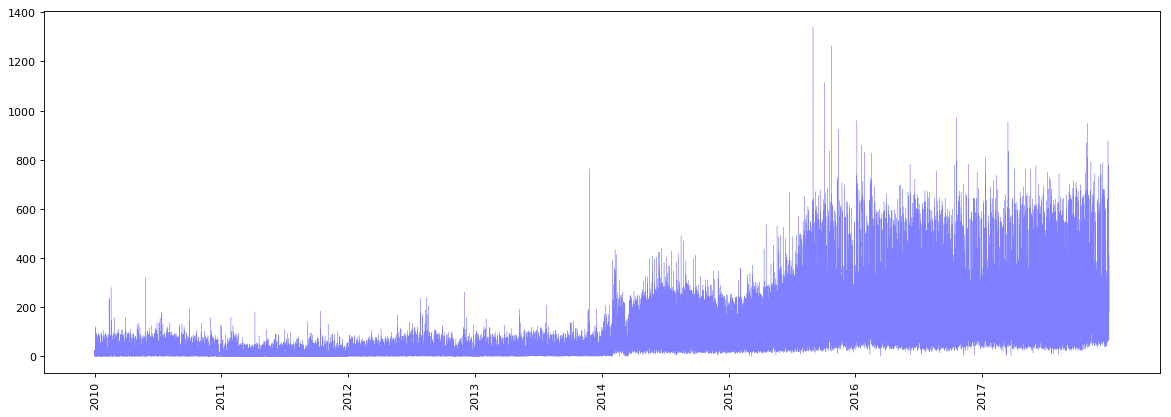

In [33]:
plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(range(0,len(df_hours)), df_hours.total, '-',color='blue', alpha=.5, linewidth=.3)
plt.xticks(tic_locations, tic_vals, rotation='vertical')
plt.show()

### plot daily totals for whole period

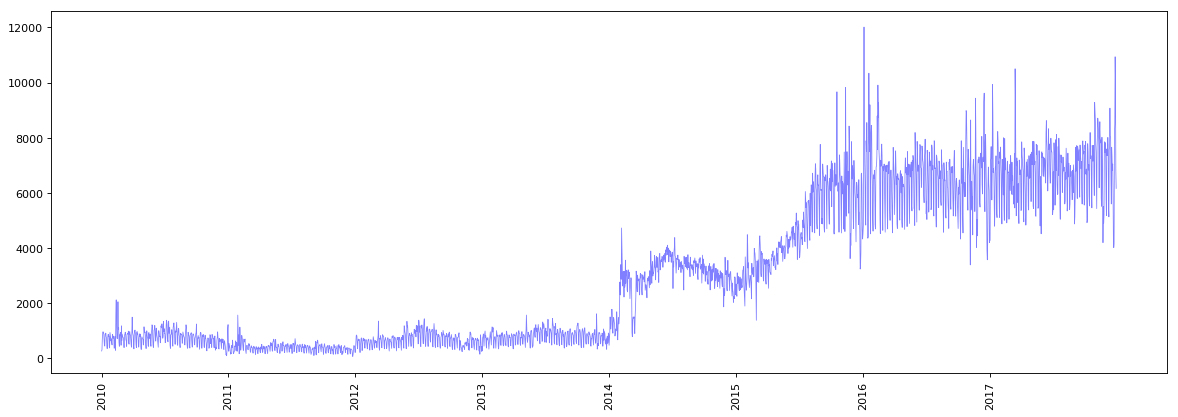

In [34]:
df_days = df.drop(['tenmin', 'hour', 'week', 'year'], axis=1).groupby('day').sum()
df_days.head()

tic_locations = []
tic_vals = range(2010,2018)
for y in tic_vals:
    tic_locations.append(np.where(df_days.index == str(y) + '-01-01')[0][0])

plot_trend(df_days, tic_locations, tic_vals, .7)

### plot weekly totals for whole period

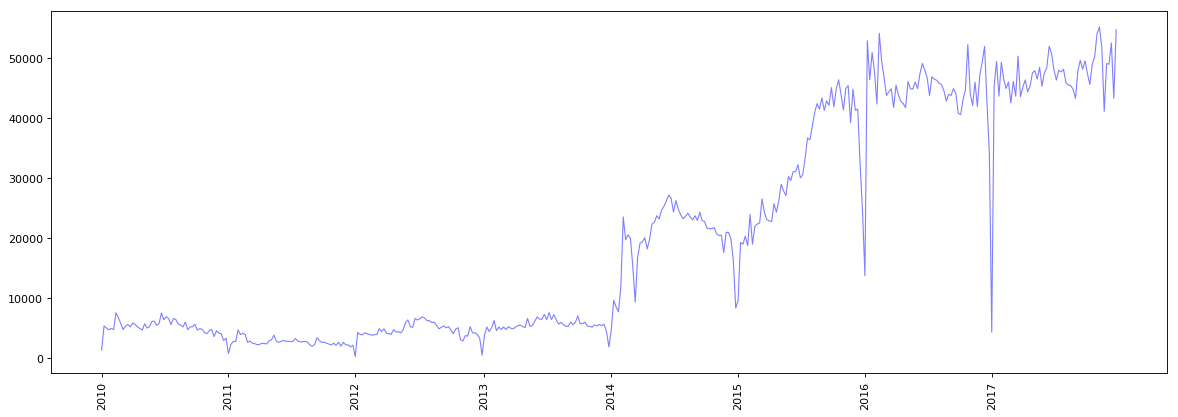

In [35]:
df_weeks = df.drop(['tenmin', 'hour', 'day', 'year'], axis=1).groupby('week').sum()

tic_locations = []
for y in tic_vals:
    tic_locations.append(np.where(df_weeks.index == str(y) + '-00')[0][0])

plot_trend(df_weeks, tic_locations, tic_vals, 1.)

### plot hourly totals for 2017

In [36]:
df17 = df[df.year==2017]

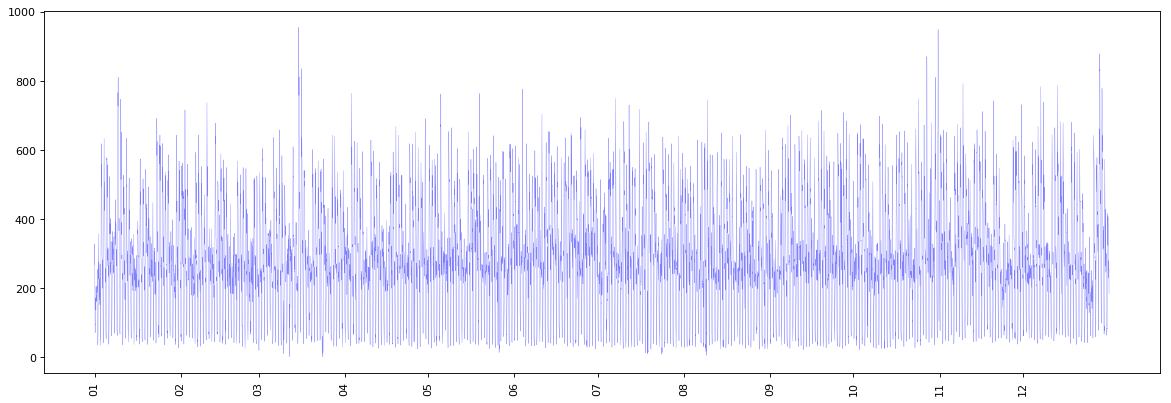

In [37]:
df17_hours = df17.drop(['tenmin', 'day', 'week', 'year'], axis=1).groupby('hour').sum()

def get_months():
    mvals = []
    for x in range(1,13):
        if x <10:
            mvals.append('0' + str(x))
        else: 
            mvals.append(str(x))
    return mvals

tic_locations = []
tic_vals = get_months()
for m in tic_vals:
    tic_locations.append(np.where(df17_hours.index == '2017-' + m + '-01-00')[0][0])
plot_trend(df17_hours, tic_locations, tic_vals)

### plot daily totals for 2017

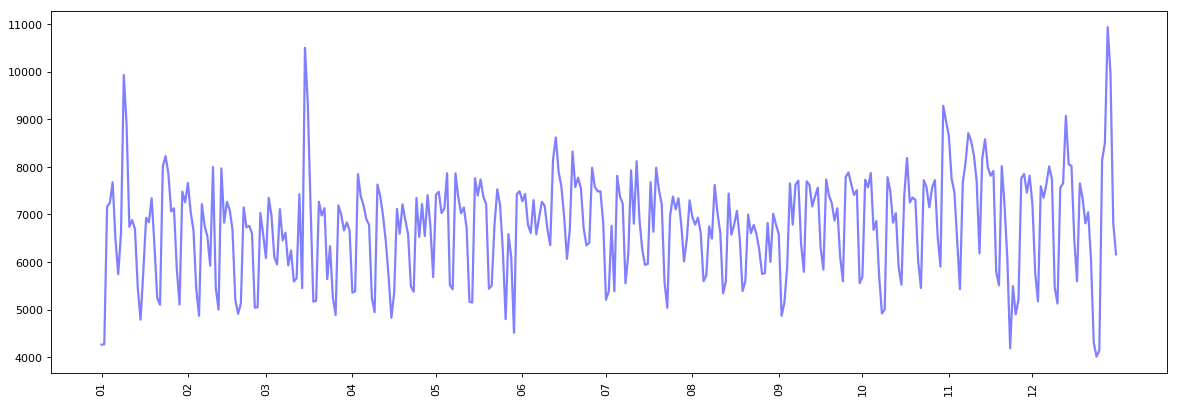

In [39]:
df17_days = df17.drop(['tenmin', 'hour', 'week', 'year'], axis=1).groupby('day').sum()

tic_locations = []
for m in tic_vals:
    tic_locations.append(np.where(df17_days.index == '2017-' + m + '-01')[0][0])

plot_trend(df17_days, tic_locations, tic_vals, 2.)

### plot hourly totals by week for 2017 (ie 52 different lines)

In [40]:
w = pd.to_datetime(pd.Series(df17_hours.index), format='%Y-%m-%d-%H').dt.strftime('%Y-%W')
w.index = df17_hours.index
df17_hours['week'] = w

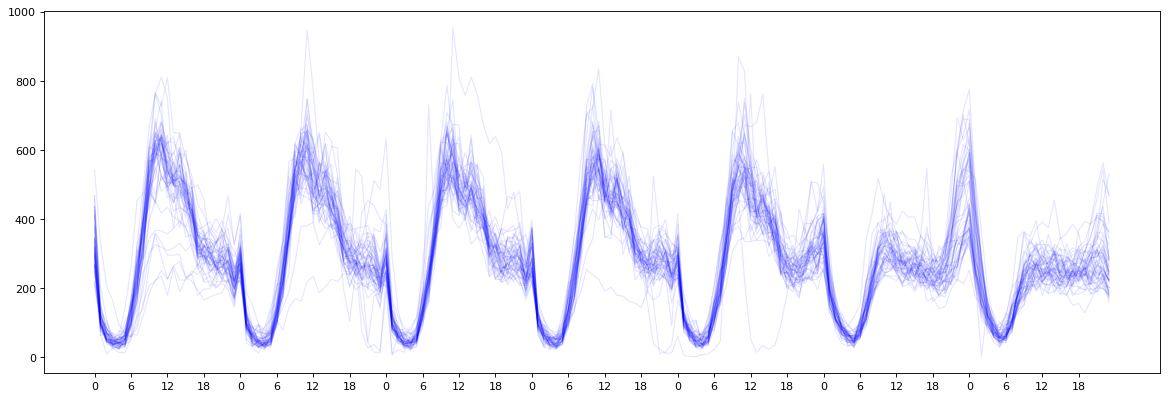

In [41]:
def get_weeks():
    mvals = []
    for x in range(1,52):
        if x <10:
            mvals.append('0' + str(x))
        else: 
            mvals.append(str(x))
    return mvals

def make_week_plot(df):
    plt.plot(range(1,169), df.total, '-', color='blue', alpha=.1, linewidth=1.)
    plt.xticks(np.arange(1, 169, 6), list(np.arange(0, 24, 6))*7, rotation='horizontal')

plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for w in get_weeks():
    make_week_plot(df17_hours[df17_hours.week=='2017-' + w])
plt.show()

# Save data for RNN analysis

As there is a lot of variation in the number of calls over time, I will use data from 2016 and 2017 only. 

In [42]:
df.drop(['hour', 'day', 'week', 'year'], axis=1).head()

,tenmin,DEP,DOB,DOF,DOHMH,DOT,DPR,DSNY,HPD,NYPD,TLC,other,total
0,2010-01-01-00-00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01-00-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-01-00-20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2010-01-01-00-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-01-00-40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df1617 = df[(df.year==2016) | (df.year==2017)]
print len(df1617)
df1617 = df1617.drop(['hour', 'day', 'week', 'year'], axis=1)
df1617.sort_values('tenmin')
df1617.to_csv('/Users/sambarrows/Dropbox/Stats/Projects/predict311/calldat1617.csv', index=False)

105264
